In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *

# Yahoo Finance
import yfinance as yf


np.random.seed(42)  
tf.random.set_seed(42) 

In [2]:
data = yf.download("AAPL", interval="1d") #stock info 
df = pd.DataFrame(data)
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
1980-12-12,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15,0.093678,0.094108,0.093678,0.094108,175884800
1980-12-16,0.086802,0.087232,0.086802,0.087232,105728000
1980-12-17,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18,0.091530,0.091959,0.091530,0.091530,73449600


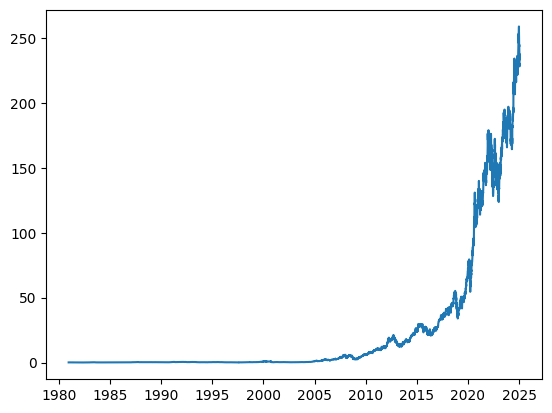

In [3]:
plt.plot(df['Close'],)#close price of stock plot

In [4]:
df['Diff'] = df['Close'] - df['Open']

df['Buy'] = (df['Diff'] < 0).astype(int)

df['Diff_5'] = df['Diff'].rolling(window=5).sum()
df['Diff_30'] = df['Diff'].rolling(window=30).sum()

df = df.drop(columns=['Volume'])
df = df.dropna()
df


Price,Close,High,Low,Open,Diff,Buy,Diff_5,Diff_30
Ticker,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,
1981-01-26,0.110867,0.111296,0.110867,0.111296,-0.000430,1,-0.001289,-0.006445
1981-01-27,0.110007,0.110867,0.110007,0.110867,-0.000859,1,-0.001719,-0.007305
1981-01-28,0.106570,0.106999,0.106570,0.106999,-0.000430,1,-0.002148,-0.007305
1981-01-29,0.102702,0.103132,0.102702,0.103132,-0.000430,1,-0.002578,-0.007305
1981-01-30,0.097116,0.097975,0.097116,0.097975,-0.000859,1,-0.003008,-0.008164
...,...,...,...,...,...,...,...,...
2025-01-13,234.399994,234.669998,229.720001,233.529999,0.869995,0,-1.589981,17.129990
2025-01-14,233.279999,236.119995,232.470001,234.750000,-1.470001,1,-3.749985,15.199997


In [5]:
#df[df.columns[1:]] = normalize(df[df.columns[1:]],norm = 'max', axis = 0)
df

Price,Close,High,Low,Open,Diff,Buy,Diff_5,Diff_30
Ticker,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,
1981-01-26,0.110867,0.111296,0.110867,0.111296,-0.000430,1,-0.001289,-0.006445
1981-01-27,0.110007,0.110867,0.110007,0.110867,-0.000859,1,-0.001719,-0.007305
1981-01-28,0.106570,0.106999,0.106570,0.106999,-0.000430,1,-0.002148,-0.007305
1981-01-29,0.102702,0.103132,0.102702,0.103132,-0.000430,1,-0.002578,-0.007305
1981-01-30,0.097116,0.097975,0.097116,0.097975,-0.000859,1,-0.003008,-0.008164
...,...,...,...,...,...,...,...,...
2025-01-13,234.399994,234.669998,229.720001,233.529999,0.869995,0,-1.589981,17.129990
2025-01-14,233.279999,236.119995,232.470001,234.750000,-1.470001,1,-3.749985,15.199997


In [6]:
X = df[['Open', 'High', 'Low', 'Diff_30', 'Diff','Diff_5']].values
y = df['Close'].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Shape: (samples, time_steps, features)

# Split data into train and test sets
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:] 

In [7]:
model = Sequential([
    LSTM(150, activation='relu', input_shape=(1,6), return_sequences=True),
    Dropout(0.2),
    Dense(1)
])
model.summary()
optimizer = Adam(learning_rate = 0.01)
model.compile(optimizer=optimizer  , loss='mse', metrics=['mae'])

C:\Users\przem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 150)         │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,351 (368.56 KB)

 Trainable params: 94,351 (368.56 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False,
    callbacks=callbacks)

Epoch 1/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1196 - mae: 0.0995 - val_loss: 150.3611 - val_mae: 9.7096
Epoch 2/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3731 - mae: 0.4592 - val_loss: 123.9359 - val_mae: 9.1736
Epoch 3/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2339 - mae: 0.3142 - val_loss: 120.0585 - val_mae: 8.4269
Epoch 4/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1618 - mae: 0.2075 - val_loss: 7.1686 - val_mae: 2.1780
Epoch 5/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1505 - mae: 0.1760 - val_loss: 3.0317 - val_mae: 1.4880
Epoch 6/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2171 - mae: 0.2788 - val_loss: 11.4416 - val_mae: 2.3564
Epoch 7/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1918 - mae: 0.2227 - val_loss: 26.4859 - val_mae: 4.2205
Epoch 8/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1789 - mae: 0.2063 - val_loss: 43.7597 - val_mae: 5.6011
Epoch 9/1000
278/278 ━━━━━━━━━━

<Axes: >

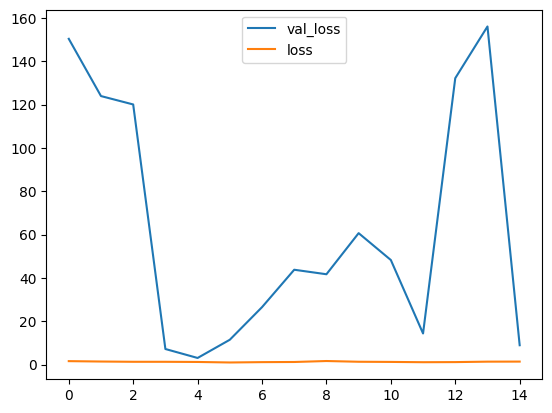

In [9]:
pd.DataFrame({'val_loss':history.history['val_loss'], 'loss' : history.history['loss']}).plot()

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


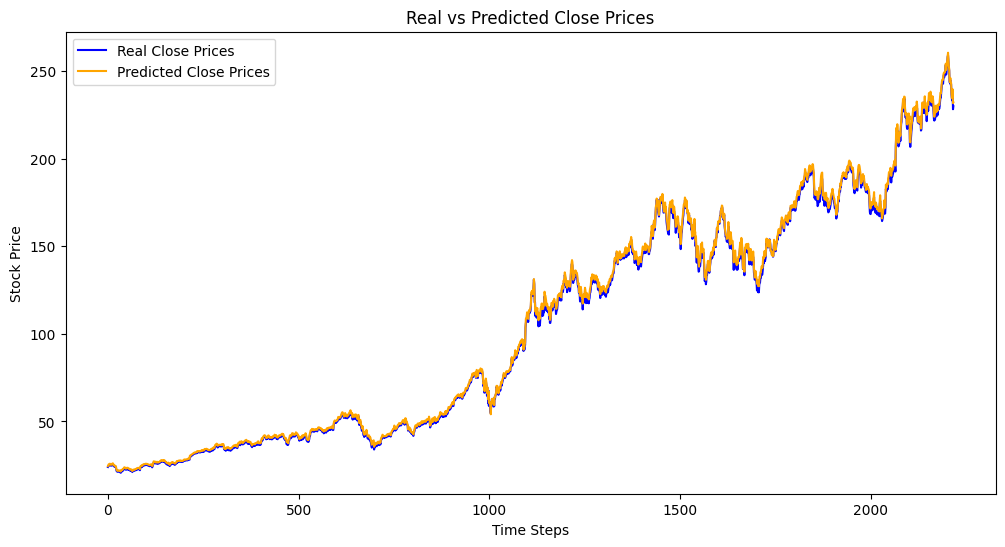

Buy prediction accuracy: 162.47%


In [10]:
y_pred = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="Real Close Prices", color="blue")
plt.plot(range(len(y_pred)), y_pred.flatten(), label="Predicted Close Prices", color="orange")
plt.title("Real vs Predicted Close Prices")
plt.xlabel("Time Steps")    
plt.ylabel("Stock Price")
plt.legend()
plt.show()
buy_pred = (y_pred > X_test[:, 0, 0])  


correct_predictions = (y_test/y_pred).mean()


print(f"Buy prediction accuracy: {correct_predictions * 100:.2f}%")



Final Money: $12984.58
Final Portfolio Value: $12984.58


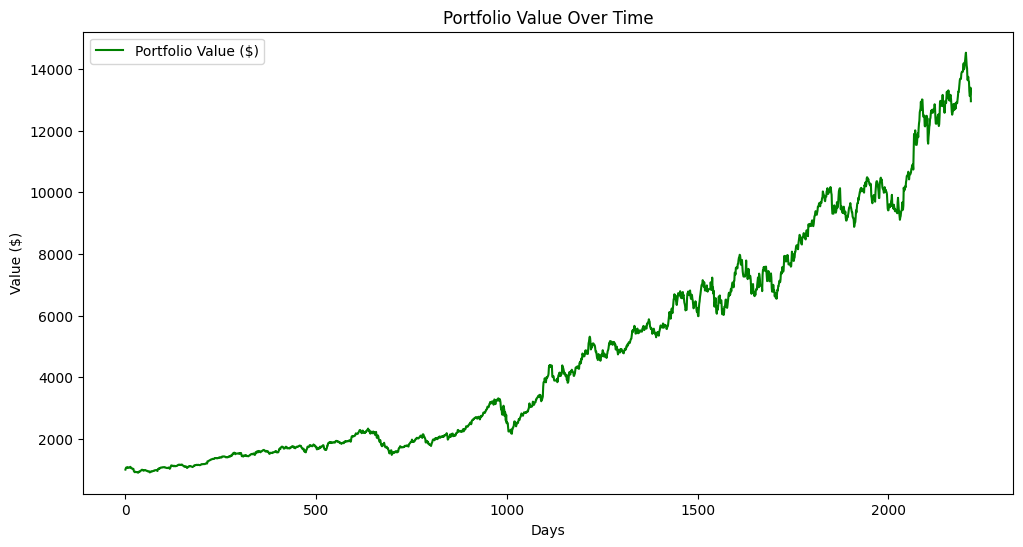

In [11]:
stock = 0
money = 1000
money_log = []
portfolio_value_log = []
buy_counter = 0
sell_counter = 0
buy_threshold = 2
sell_threshold = 2

# Predicted and actual prices
close_prices = y_pred[:, 0].flatten()  
open_prices = X_test[:, 0, 0].tolist() 

# Simulate trading strategy
for i in range(0, len(close_prices) - 1):
    # Buy logic
    if close_prices[i] > open_prices[i] and money >= open_prices[i]:
        buy_counter += 1
        if buy_counter >= buy_threshold:
            while money >= open_prices[i]:
                stock += 1
                money -= open_prices[i]
    else:
        buy_counter = 0  

    # Sell logic
    if close_prices[i] < open_prices[i]:
        sell_counter += 1
        if sell_counter >= sell_threshold and stock > 0:
            money += close_prices[i] * stock  
            stock = 0
    else:
        sell_counter = 0  

    portfolio_value = money + stock * close_prices[i]
    portfolio_value_log.append(portfolio_value)
    money_log.append(money)

# Final sell if still holding stock
if stock > 0:
    money += stock * close_prices[-1]
    portfolio_value = money
else:
    portfolio_value = portfolio_value_log[-1]

print(f"Final Money: ${money:.2f}")
print(f"Final Portfolio Value: ${portfolio_value:.2f}")

plt.figure(figsize=(12, 6))

plt.plot(portfolio_value_log, label="Portfolio Value ($)", linestyle="-", color="green")


plt.title("Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Value ($)")
plt.legend()
plt.show()

In [12]:

time_steps = 1

X2 = []
y2 = []

for i in range(time_steps, len(df)):
    X2.append(df[['Open', 'High', 'Low', 'Close','Diff_5','Diff_30']].values[i-time_steps:i])
    y2.append(df['Diff'].values[i])

X2, y2 = np.array(X2), np.array(y2)

# Split data into train and test sets
split_index = int(len(X2) * 0.8)  # 80% for training, 20% for testing
X2_train, X2_test = X2[:split_index], X2[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]

In [13]:
model2 = Sequential([
    LSTM(150, activation='relu', input_shape=(1,6), return_sequences=True),
    Dropout(0.1),
    Dense(1)
])
model2.summary()
optimizer = Adam(learning_rate = 0.001)
model2.compile(optimizer=optimizer  , loss='mse', metrics=['mae'])

C:\Users\przem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 150)         │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 1)           │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,351 (368.56 KB)

 Trainable params: 94,351 (368.56 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history2 = model2.fit(
    X2_train, y2_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X2_test, y2_test),
    verbose=1,
    shuffle=False,
    callbacks=callbacks2)

Epoch 1/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9.9364e-04 - mae: 0.0087 - val_loss: 2.8878 - val_mae: 1.0876
Epoch 2/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6767e-04 - mae: 0.0093 - val_loss: 2.9424 - val_mae: 1.1021
Epoch 3/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5434e-04 - mae: 0.0084 - val_loss: 2.9155 - val_mae: 1.0933
Epoch 4/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5829e-04 - mae: 0.0088 - val_loss: 2.8973 - val_mae: 1.0885
Epoch 5/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5453e-04 - mae: 0.0084 - val_loss: 2.8927 - val_mae: 1.0875
Epoch 6/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5480e-04 - mae: 0.0083 - val_loss: 2.8919 - val_mae: 1.0871
Epoch 7/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5360e-04 - mae: 0.0087 - val_loss: 2.9122 - val_mae: 1.0920
Epoch 8/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5323e-04 - mae: 0.0083 - val_loss: 2.9018 - val_mae: 1.0893
Epoch 9/

<Axes: >

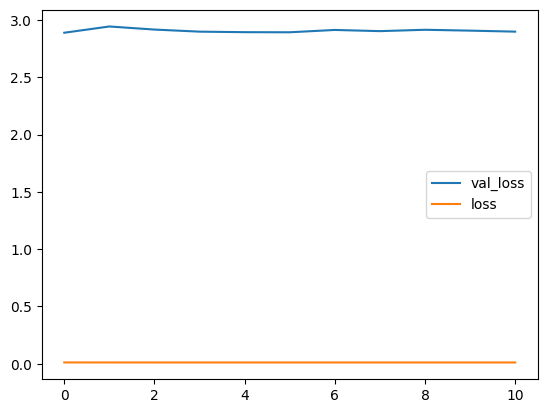

In [15]:
pd.DataFrame({'val_loss':history2.history['val_loss'], 'loss' : history2.history['loss']}).plot()

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


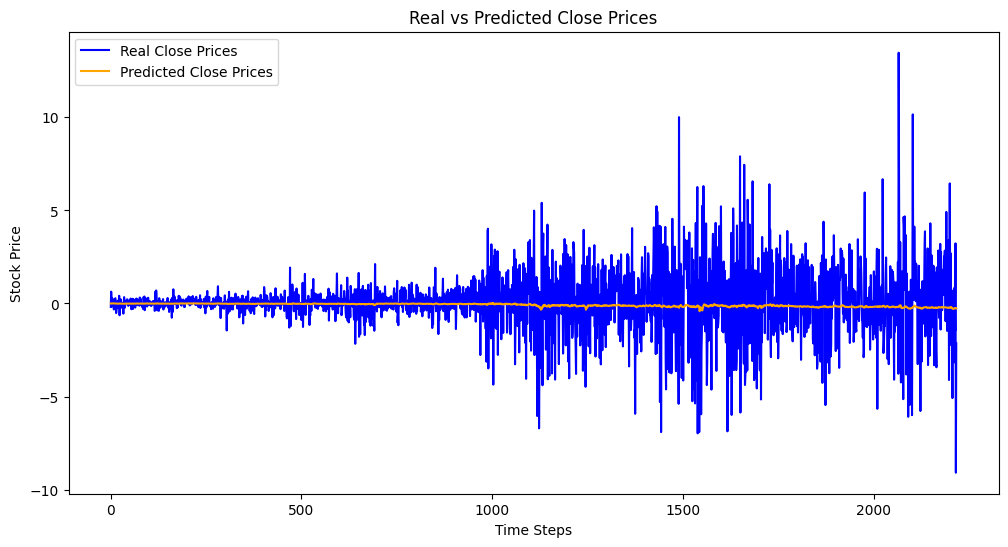

[[[-0.00133444]]

 [[-0.00215425]]

 [[ 0.00339665]]

 ...

 [[-0.25034618]]

 [[-0.23919816]]

 [[-0.26311463]]]


In [16]:
y2_pred = model2.predict(X2_test)
# Ensure y2_test and y2_pred have the same shape
y2_test_flat = y2_test.flatten()
y2_pred_flat = y2_pred.flatten()[:len(y2_test_flat)]  # Slice to match the length of y2_test_flat

# Create a shared x-axis based on the actual number of samples
x_axis = range(len(y2_test_flat))

# Plot the real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(x_axis, y2_test_flat, label="Real Close Prices", color="blue")
plt.plot(x_axis, y2_pred_flat, label="Predicted Close Prices", color="orange")
plt.title("Real vs Predicted Close Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
print(y2_pred)

Final Money: $6175.28
Final Portfolio Value: $6175.28


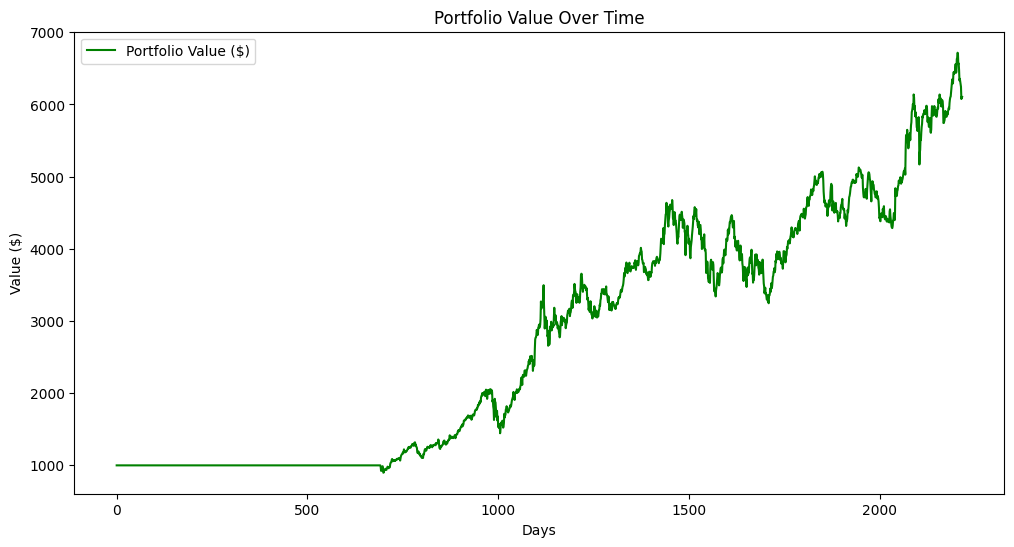


Trade Log:
    Day      Action       Price  Stocks  Money Gained
0  2218  Final Sell  237.350006       0   6175.279898


In [21]:
import matplotlib.pyplot as plt

# Parameters
stock = 0
money = 1000
money_log = []
portfolio_value_log = []
buy_threshold = -0.05
sell_threshold = 0.05
sell_counter = 0
buy_counter = 0
buy_threshold_c = 2
sell_threshold_c = 2

# Predicted and actual prices
diff_pred = y2_pred_flat  # Use predictions from the second model
open_prices = X2_test[:, 0, 0].tolist()

# Trade logs
trade_log = []

# Simulate trading strategy
for i in range(0, len(diff_pred) - 1):
    # Buy logic
    if diff_pred[i] < buy_threshold and money >= open_prices[i]:
        buy_counter += 1
        if buy_counter >= buy_threshold_c:
            while money >= open_prices[i]:
                stock += 1
                money -= open_prices[i]
    else:
        buy_counter = 0

    # Sell logic
    if diff_pred[i] > sell_threshold:
        sell_counter += 1
        if sell_counter >= sell_threshold_c and stock > 0:
            money += open_prices[i] * stock
            trade_log.append(
                {"Day": i, "Action": "Sell", "Price": open_prices[i], "Stocks": 0, "Money Gained": money}
            )
            stock = 0
    else:
        sell_counter = 0

    # Portfolio value calculation
    portfolio_value = money + stock * open_prices[i]
    portfolio_value_log.append(portfolio_value)
    money_log.append(money)

# Final sell if still holding stock
if stock > 0:
    money += stock * open_prices[-1]
    trade_log.append(
        {"Day": len(diff_pred), "Action": "Final Sell", "Price": open_prices[-1], "Stocks": 0, "Money Gained": money}
    )
    portfolio_value = money
else:
    portfolio_value = portfolio_value_log[-1]

# Print final results
print(f"Final Money: ${money:.2f}")
print(f"Final Portfolio Value: ${portfolio_value:.2f}")

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_log, label="Portfolio Value ($)", linestyle="-", color="green")
plt.title("Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Value ($)")
plt.legend()
plt.show()

# Display trade log
import pandas as pd

trade_log_df = pd.DataFrame(trade_log)
print("\nTrade Log:")
print(trade_log_df)
